# Hate Speech Detection with BERT, Adversarial Training (FGM), and Explainability

This notebook implements a hate speech/offensive language detection model based on the project proposal. It fine-tunes a pre-trained BERT model using PyTorch, incorporating:

1.  **Data Loading & Preprocessing:** Handles TSV/CSV files, basic text cleaning, and preparation for BERT.
2.  **BERT Fine-tuning:** Uses Hugging Face Transformers for model loading and training.
3.  **Adversarial Training:** Implements the Fast Gradient Method (FGM) on embeddings as an optional technique to improve robustness.
4.  **Evaluation:** Calculates standard classification metrics (Accuracy, F1, Precision, Recall) and generates reports/visualizations.
5.  **Explainability:** Provides basic attention visualization to understand model focus.
6.  **Configuration:** Key parameters are set in a dedicated cell for easy experimentation.
7.  **Early Stopping:** Optional mechanism to prevent overfitting.
8.  **Artifact Saving:** Saves the trained model, tokenizer, results, and plots.

## 1. Setup and Imports

Import necessary libraries and set up basic configurations.

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import os
import json
import time
import random
from copy import deepcopy
from typing import Dict, List, Tuple, Optional
from tqdm.auto import tqdm
import re

2025-05-12 19:00:55.723691: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-12 19:00:55.741129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747069255.760607   16509 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747069255.766597   16509 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747069255.781550   16509 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## 2. Configuration

Set hyperparameters, file paths, model name, and feature flags here. Adjust these values for your specific dataset and experiments.

In [93]:
'''print("Working dir:", os.getcwd())
print("Root contents:", os.listdir(os.getcwd()))
print("Data folder contents:", os.listdir(os.path.join(os.getcwd(), 'HASOCData')))
print("HASOCData contents (if any):", os.listdir(os.path.join(os.getcwd(), 'HASOCData')))'''


'print("Working dir:", os.getcwd())\nprint("Root contents:", os.listdir(os.getcwd()))\nprint("Data folder contents:", os.listdir(os.path.join(os.getcwd(), \'HASOCData\')))\nprint("HASOCData contents (if any):", os.listdir(os.path.join(os.getcwd(), \'HASOCData\')))'

In [7]:
# --- Core Configuration ---
MODEL_NAME = 'bert-base-uncased'
MAX_LEN = 128  # Max sequence length for BERT tokenizer
BATCH_SIZE = 16 # Reduce if facing GPU memory issues
EPOCHS = 10     # Number of training epochs
LEARNING_RATE = 1e-5 # Standard learning rate for BERT fine-tuning
SEED = 42      # Random seed for reproducibility
OUTPUT_DIR = 'model_output' # Directory to save model, results, plots
VAL_SPLIT_SIZE = 0.1 # Proportion of training data to use for validation

# --- Feature Flags ---
USE_FGM = True # Set to True to enable Fast Gradient Method adversarial training
ADVERSARIAL_EPS = 0.5 # Epsilon for FGM perturbation (if USE_FGM is True)
USE_EARLY_STOPPING = True # Set to True to enable early stopping
PATIENCE = 3 # Number of epochs to wait for improvement before stopping (if USE_EARLY_STOPPING is True)

# --- Dataset Configuration ---
BASE_DIR = os.getcwd()
print("Base dir:", BASE_DIR)
# Choose one dataset type to configure
DATASET_TYPE = 'HASOC' # Options: 'OLID', 'HASOC', 'OffenseEval'
# For OLID & OffenseEval use 'a','b','c'; for HASOC use '1','2','3'
SUBTASK = '1'        # e.g. HASOC subtask 1 (task_1), 2 (task_2), or 3 (task_3)


# File paths
if DATASET_TYPE == 'OLID':
    DATA_DIR   = os.path.join(BASE_DIR, 'OlidPreprcessed')
    TRAIN_FILE = os.path.join(DATA_DIR, 'OLID_Tain_ATUSER_URL_EmojiRemoved_Pedro.txt')
    print(f"Train file: {TRAIN_FILE}")
    
    # pick the right test file for a, b or c
    TEST_FILE  = os.path.join(
        DATA_DIR,
        f'OLID_TEST_{SUBTASK.upper()}_ATUSER_URL_EmojiRemoved_Pedro.txt'
    )
    print(f"Test file: {TEST_FILE}")
    TEST_LABELS_FILE = None
    TEXT_COLUMN = 'tweet'
    
    # label column + map per subtask
    LABEL_COLUMN = f'subtask_{SUBTASK.lower()}'
    if SUBTASK == 'a':
        LABEL_MAP = {'NOT': 0, 'OFF': 1}
    elif SUBTASK == 'b':
        LABEL_MAP = {'UNT': 0, 'TIN': 1}
    else:  # c
        LABEL_MAP = {'IND': 0, 'GRP': 1, 'OTH': 2}
    NUM_LABELS = len(LABEL_MAP)


elif DATASET_TYPE == 'HASOC':
    # include the Project_folder in path
    DATA_DIR    = os.path.join(BASE_DIR, 'HASOCData')
    TRAIN_FILE  = os.path.join(DATA_DIR, 'english_dataset.tsv')
    print(f"Train file: {TRAIN_FILE}")
    TEST_FILE   = os.path.join(DATA_DIR, 'hasoc2019_en_test-2919.tsv')
    TEST_LABELS_FILE = None

    TEXT_COLUMN  = 'tweet'
    LABEL_COLUMN = f'task_{SUBTASK}'
    if SUBTASK == '1':
        LABEL_MAP = {'NOT': 0, 'HOF': 1}
    elif SUBTASK == '2':
        LABEL_MAP = {'HATE': 0, 'OFFN': 1, 'PRFN': 2}
    else:  # '3'
        LABEL_MAP = {'UNT': 0, 'TIN': 1}
    NUM_LABELS = len(LABEL_MAP)


elif DATASET_TYPE == 'OffenseEval':
    DATA_DIR = os.path.join(BASE_DIR, 'OffenseEval')
    # Train: all nine parts for subtask A, or distant files for B/C
    if SUBTASK == 'a':
        part_paths = [os.path.join(DATA_DIR, f'task_a_part{i}.xlsx') for i in range(1, 10)]
        # load & concat all parts:
        TRAIN_FILE = None
        train_dfs = [pd.read_excel(p) for p in part_paths if os.path.exists(p)]
        df_train_all = pd.concat(train_dfs, ignore_index=True)
    elif SUBTASK == 'b':
        TRAIN_FILE = os.path.join(DATA_DIR, 'task_b_distant.xlsx')
    else:  # 'c'
        TRAIN_FILE = os.path.join(DATA_DIR, 'task_c_distant_ann.xlsx')

    TEST_DIR = DATA_DIR
    TEST_FILE = os.path.join(TEST_DIR, f'test_{SUBTASK}.tsv')  # or whatever your naming is
    TEST_LABELS_FILE = None

    TEXT_COLUMN  = 'tweet'
    LABEL_COLUMN = f'subtask_{SUBTASK}'
    if SUBTASK == 'a':
        LABEL_MAP = {'NOT': 0, 'OFF': 1}
    elif SUBTASK == 'b':
        LABEL_MAP = {'UNT': 0, 'TIN': 1}
    else:  # 'c'
        LABEL_MAP = {'IND': 0, 'GRP': 1, 'OTH': 2}
    NUM_LABELS = len(LABEL_MAP)

else:
    raise ValueError("Invalid DATASET_TYPE. Choose from 'OLID', 'HASOC', 'OffenseEval'.")

# --- Create output directory ---
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Save Configuration to JSON (for record keeping) ---
config_dict = {
    'MODEL_NAME': MODEL_NAME,
    'MAX_LEN': MAX_LEN,
    'BATCH_SIZE': BATCH_SIZE,
    'EPOCHS': EPOCHS,
    'LEARNING_RATE': LEARNING_RATE,
    'SEED': SEED,
    'OUTPUT_DIR': OUTPUT_DIR,
    'DATASET_TYPE': DATASET_TYPE,
    'BASE_DIR': BASE_DIR,
    'TRAIN_FILE': locals().get('TRAIN_FILE'),
    'TEST_FILE': locals().get('TEST_FILE'),
    'TEST_LABELS_FILE': TEST_LABELS_FILE,
    'TEXT_COLUMN': TEXT_COLUMN,
    'LABEL_COLUMN': LABEL_COLUMN,
    'LABEL_MAP': LABEL_MAP,
    'NUM_LABELS': NUM_LABELS,
    'VAL_SPLIT_SIZE': VAL_SPLIT_SIZE,
    'USE_FGM': USE_FGM,
    'ADVERSARIAL_EPS': ADVERSARIAL_EPS if USE_FGM else None,
    'USE_EARLY_STOPPING': USE_EARLY_STOPPING,
    'PATIENCE': PATIENCE if USE_EARLY_STOPPING else None
}

config_filename = f"config_{DATASET_TYPE}.json"
config_path     = os.path.join(OUTPUT_DIR, config_filename)
with open(config_path, 'w') as f:
    json.dump(config_dict, f, indent=4)

print(f"Configuration saved to {config_path}")

Base dir: /
Train file: /HASOCData/english_dataset.tsv
Configuration saved to model_output/config_HASOC.json


## 3. Environment Setup

Set random seeds for reproducibility and select the compute device (GPU if available, otherwise CPU).

In [8]:
def set_seed(seed_value: int):
    """Sets the seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
        # These two lines are for deterministic behavior, can slightly slow down training
        # torch.backends.cudnn.deterministic = True
        # torch.backends.cudnn.benchmark = False

set_seed(SEED)

# Select device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'Using GPU: {torch.cuda.get_device_name(0)}')
else:
    device = torch.device("cpu")
    print('Using CPU')

# Rough Training Time Estimate (for RTX 2080 Ti):
# Depending on dataset size (e.g., ~10k-100k samples) and MAX_LEN,
# expect training time to be roughly:
# - Small dataset (~10k): Few minutes per epoch.
# - Medium dataset (~50k-100k): 15-60 minutes per epoch.
# - Large dataset (>100k): Potentially several hours per epoch.
# FGM adds a small overhead (extra forward/backward pass per step).

Using GPU: NVIDIA GeForce RTX 2080 Ti


## 4. Data Loading and Preprocessing

Load data from files, perform basic cleaning, map labels, and split into train/validation/test sets.

In [9]:
def preprocess_text(text: str) -> str:
    """Basic text cleaning for social media text."""
    if not isinstance(text, str):
        text = str(text)
    text = text.lower() # Lowercase
    # Replace user mentions (keeping a generic token might be useful)
    text = re.sub(r'@\w+', '@USER', text)
    # Optional: Replace URLs
    text = re.sub(r'http\S+|www.\S+', 'HTTPURL', text)
    # Optional: Remove punctuation (Generally NOT recommended for BERT initially)
    # import string
    # text = text.translate(str.maketrans('', '', string.punctuation))
    # Optional: Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Quick sanity‐check
assert preprocess_text("Hello  WORLD!!") == "hello world!!"
assert preprocess_text("@john check this out") == "@USER check this out"
print("Preprocessed text looks good.")


Preprocessed text looks good.


In [10]:
# Cell 3: Robust file loading + tests
def load_data(file_path: str, sep: str = '\t') -> Optional[pd.DataFrame]:
    """Load a TSV or CSV file, falling back if necessary."""
    print(f"Loading {file_path!r} (sep='{sep}')…")
    if not os.path.exists(file_path):
        print(f"❌ File not found: {file_path}")
        return None

    try:
        df = pd.read_csv(file_path, sep=sep, quoting=3, on_bad_lines='warn')
        print(f"✔️ Loaded with sep='{sep}', shape={df.shape}")
        return df
    except Exception as e:
        print(f"⚠️ Failed with sep='{sep}': {e}")

    if sep == '\t':
        print("→ Retrying with sep=','…")
        try:
            df = pd.read_csv(file_path, on_bad_lines='warn')
            print(f"✔️ Loaded with sep=',', shape={df.shape}")
            return df
        except Exception as e2:
            print(f"❌ Still failed: {e2}")

    return None

In [11]:
# Cell 4: Full pipeline for OLID / HASOC / OffenseEval
def load_and_preprocess_data(
    train_path: str,
    test_path: str,
    text_col: str,
    label_col: str,
    label_map: Dict[str, int],
    test_labels_path: Optional[str] = None,
    val_split: float = 0.1,
    seed: int = 42
) -> Tuple[pd.DataFrame, pd.DataFrame, Optional[pd.DataFrame]]:
    """
    1) Loads train/test from disk
    2) Filters out any rows whose label_col isn't in label_map.keys()
    3) Applies preprocess_text, maps labels → ints, drops NaNs
    4) Stratified train/val split
    5) Returns (train_df, val_df, test_df) where test_df may lack 'label'
    """
    # --- 1. Load DataFrames ---
    df_train = load_data(train_path)
    if df_train is None:
        raise RuntimeError(f"Cannot load train data at {train_path}")
    df_test = load_data(test_path)  # may be None

    # --- 2. Validate required columns in train ---
    missing = {text_col, label_col} - set(df_train.columns)
    if missing:
        raise ValueError(f"Train data missing columns: {missing}")

    # --- 3. Filter/Map train labels ---
    # Keep only rows whose raw label is in label_map (drops e.g. HASOC 'NONE')
    df_train = df_train[df_train[label_col].isin(label_map.keys())].reset_index(drop=True)
    # Map to ints; drop any that still map to NaN
    df_train['label'] = df_train[label_col].map(label_map)
    df_train.dropna(subset=['label'], inplace=True)
    df_train['label'] = df_train['label'].astype(int)

    # --- 4. Clean train text ---
    df_train['clean_text'] = df_train[text_col].apply(preprocess_text)
    before = len(df_train)
    df_train.dropna(subset=['clean_text'], inplace=True)
    df_train = df_train[df_train['clean_text'].str.len() > 0]
    if len(df_train) < before:
        print(f"Dropped {before - len(df_train)} invalid train rows")
    
    # --- 5. Process test set if available ---
    df_test_clean: Optional[pd.DataFrame] = None
    if df_test is not None and text_col in df_test.columns:
        df_test['clean_text'] = df_test[text_col].apply(preprocess_text)

        if label_col in df_test.columns:
            # Filter/mapping analogous to train
            df_test = df_test[df_test[label_col].isin(label_map.keys())].reset_index(drop=True)
            df_test['label'] = df_test[label_col].map(label_map)
            df_test.dropna(subset=['label'], inplace=True)
            df_test['label'] = df_test['label'].astype(int)
            df_test_clean = df_test[['clean_text', 'label']].copy()
        else:
            # unlabeled (OLID test); keep id if present
            cols = ['clean_text']
            if 'id' in df_test.columns:
                cols.insert(0, 'id')
            df_test_clean = df_test[cols].copy()
        
        # final drop of empty text
        before_test = len(df_test_clean)
        df_test_clean.dropna(subset=['clean_text'], inplace=True)
        df_test_clean = df_test_clean[df_test_clean['clean_text'].str.len() > 0]
        if len(df_test_clean) < before_test:
            print(f"Dropped {before_test - len(df_test_clean)} invalid test rows")

    # --- 6. Train/Val split ---
    if df_train['label'].nunique() < 2 or len(df_train) < 2:
        raise RuntimeError("Not enough classes or samples for train/val split")
    try:
        df_tr, df_val = train_test_split(
            df_train[['clean_text','label']],
            test_size=val_split,
            random_state=seed,
            stratify=df_train['label']
        )
    except ValueError:
        print("Stratified split failed, retrying without stratification")
        df_tr, df_val = train_test_split(
            df_train[['clean_text','label']],
            test_size=val_split,
            random_state=seed
        )

    return (
        df_tr.reset_index(drop=True),
        df_val.reset_index(drop=True),
        df_test_clean.reset_index(drop=True) if df_test_clean is not None else None
    )

In [12]:
df_train, df_val, df_test = load_and_preprocess_data(
    train_path       = TRAIN_FILE,
    test_path        = TEST_FILE,
    text_col         = TEXT_COLUMN,
    label_col        = LABEL_COLUMN,
    label_map        = LABEL_MAP,
    test_labels_path = TEST_LABELS_FILE,
    val_split        = VAL_SPLIT_SIZE,
    seed             = SEED
)

print(f"▶️ Train: {len(df_train)} rows; Val: {len(df_val)} rows; "
      f"Test: {len(df_test) if df_test is not None else 'N/A'}")

print("Train label dist:\n", df_train['label'].value_counts(normalize=True))
print("Val   label dist:\n", df_val['label'].value_counts(normalize=True))
if df_test is not None and 'label' in df_test.columns:
    print("Test  label dist:\n", df_test['label'].value_counts(normalize=True))
else:
    print("Test  label dist:\n N/A (test set unlabeled)")

Loading '/HASOCData/english_dataset.tsv' (sep='	')…
✔️ Loaded with sep='	', shape=(5852, 5)
Loading '/HASOCData/hasoc2019_en_test-2919.tsv' (sep='	')…
✔️ Loaded with sep='	', shape=(1153, 5)
▶️ Train: 5266 rows; Val: 586 rows; Test: 1153
Train label dist:
 label
0    0.613559
1    0.386441
Name: proportion, dtype: float64
Val   label dist:
 label
0    0.614334
1    0.385666
Name: proportion, dtype: float64
Test  label dist:
 label
0    0.750217
1    0.249783
Name: proportion, dtype: float64


## 5. PyTorch Dataset and DataLoader

Create a custom PyTorch `Dataset` to handle text tokenization on-the-fly and `DataLoader` for batching.

In [13]:
class TextClassificationDataset(Dataset):
    """PyTorch Dataset for text classification tasks."""
    def __init__(self, texts: List[str], labels: List[int], tokenizer: BertTokenizer, max_len: int):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self) -> int:
        return len(self.texts)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        text = str(self.texts[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
        }
        # only add labels if we have them
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# --- Initialize Tokenizer ---
print(f"Loading tokenizer for model: {MODEL_NAME}")
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# --- Create train/val datasets & loaders ---
train_dataset = TextClassificationDataset(
    texts=df_train['clean_text'].tolist(),
    labels=df_train['label'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)
val_dataset = TextClassificationDataset(
    texts=df_val['clean_text'].tolist(),
    labels=df_val['label'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

# persistent_workers = True if torch.__version__ >= '1.7' and torch.cuda.is_available() else False
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=0,)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=0)

print(f"▶️ Train loader: {len(train_dataset)} samples")
print(f"▶️ Val   loader: {len(val_dataset)} samples")

# --- Create test loader only if 'label' exists ---
test_loader = None
if df_test is not None and 'label' in df_test.columns and len(df_test) > 0:
    test_dataset = TextClassificationDataset(
        texts=df_test['clean_text'].tolist(),
        labels=df_test['label'].tolist(),
        tokenizer=tokenizer,
        max_len=MAX_LEN
    )
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                             num_workers=0)
    print(f"▶️ Test  loader: {len(test_dataset)} samples")
else:
    print("ℹ️ No labeled test set found → skipping test DataLoader")

Loading tokenizer for model: bert-base-uncased
▶️ Train loader: 5266 samples
▶️ Val   loader: 586 samples
▶️ Test  loader: 1153 samples


## 6. Model Loading

Load the pre-trained BERT model for sequence classification.

In [14]:
print(f"Loading pre-trained model: {MODEL_NAME}")
try:
    model = BertForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=NUM_LABELS, # Binary classification
        # output_attentions=True, # Set to True if you want attentions *during training*
        # output_hidden_states=True, # Set to True if you want hidden states *during training*
    )
except Exception as e:
    raise SystemExit(f"Failed to load model {MODEL_NAME}: {e}. Check model name and internet connection.")

# Move model to the appropriate device
model.to(device)
print("Model loaded and moved to device.")

Loading pre-trained model: bert-base-uncased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded and moved to device.


## 7. Adversarial Training (FGM)

Define the Fast Gradient Method (FGM) class to perturb word embeddings during training. This is applied only if `USE_FGM` is `True`.

In [15]:
class FGM:
    """
    Fast Gradient Method (FGM) for adversarial training on word embeddings.
    Applies perturbation to the model's embedding matrix.
    """
    def __init__(self, model: nn.Module, emb_name: str = 'word_embeddings', epsilon: float = 1.0):
        self.model = model
        self.epsilon = epsilon
        self.emb_name = emb_name # Usually 'word_embeddings' in BERT
        self.backup = {}
        self.embedding_layer_param = None

        # Find the parameter corresponding to the embedding layer dynamically
        for name, param in self.model.named_parameters():
            # Check if the parameter's name contains the embedding layer name
            if self.emb_name in name:
                print(f"FGM: Found embedding layer parameter: {name}")
                self.embedding_layer_param = param
                self.embedding_param_name = name
                break

        if self.embedding_layer_param is None:
            print(f"Warning: FGM could not find embedding layer parameter named like '{self.emb_name}'. Adversarial training will be disabled.")

    def attack(self):
        """Calculates and applies the perturbation."""
        # Only attack during training and if the embedding parameter was found
        if self.embedding_layer_param is None or not self.model.training:
            return

        # Get the parameter and its gradient
        param = self.embedding_layer_param
        if param.requires_grad and param.grad is not None:
             self.backup[self.embedding_param_name] = param.data.clone()
             # Calculate the perturbation r_at
             norm = torch.norm(param.grad)
             if norm != 0 and not torch.isnan(norm):
                r_at = self.epsilon * param.grad / norm
                param.data.add_(r_at) # Apply the perturbation
             # else:
                # print(f"Warning: Zero or NaN norm for gradient of {self.embedding_param_name}. Skipping perturbation.")
        # else:
             # print(f"Warning: Gradient for {self.embedding_param_name} is None or requires_grad=False. Skipping FGM attack for this step.")


    def restore(self):
        """Restores the original embedding weights."""
        if self.embedding_layer_param is None:
            return

        # Restore the parameter data from backup
        if self.embedding_param_name in self.backup:
            self.embedding_layer_param.data = self.backup[self.embedding_param_name]
        self.backup = {} # Clear the backup

# Initialize FGM if enabled
fgm = None
if USE_FGM:
    print("Initializing FGM...")
    # For Hugging Face BERT, the embeddings are typically model.bert.embeddings.word_embeddings.weight
    # We need to find the parameter corresponding to this weight tensor.
    # The FGM class now searches for the parameter name containing 'word_embeddings'.
    fgm = FGM(model, emb_name='word_embeddings', epsilon=ADVERSARIAL_EPS)
    if fgm.embedding_layer_param is None:
        print("Disabling FGM as embedding layer parameter was not found.")
        USE_FGM = False # Disable if initialization failed
else:
    print("FGM Adversarial Training is disabled.")

Initializing FGM...
FGM: Found embedding layer parameter: bert.embeddings.word_embeddings.weight


## 8. Training Loop

Define functions for a single training epoch and evaluation, then implement the main training loop.

In [16]:
def train_epoch(model: nn.Module, data_loader: DataLoader, loss_fn: nn.Module, optimizer: torch.optim.Optimizer, device: torch.device, scheduler: torch.optim.lr_scheduler._LRScheduler, n_examples: int, use_fgm: bool, fgm_instance: FGM | None):
    """Performs a single training epoch."""
    model.train() # Set model to training mode
    total_loss = 0
    correct_predictions = 0

    # Wrap your DataLoader
    loop = tqdm(
        enumerate(data_loader),
        total=len(data_loader),
        desc=f"Batches trained",
        leave=False
    )

    for batch_num, batch in loop:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # --- Standard Forward & Backward Pass ---
        optimizer.zero_grad() # Zero gradients at the start of the batch

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=None)    # labels=None for forward pass
        logits = outputs.logits
        loss = loss_fn(logits, labels)  # Use the loss function with class weights

        total_loss += loss.item()

        # Calculate accuracy for the batch
        preds = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(preds == labels).item() # Use .item() for scalar

        # Standard backward pass to calculate gradients
        loss.backward()

        # --- FGM Attack (if enabled) ---
        if use_fgm and fgm_instance is not None:
            # Check if FGM was successfully initialized and can attack
            if fgm_instance.embedding_layer_param is not None and fgm_instance.embedding_layer_param.grad is not None:
                fgm_instance.attack() # Perturb embeddings based on current gradients

                # Adversarial forward pass
                outputs_adv_logits = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=None
                ).logits
                loss_adv = loss_fn(outputs_adv_logits, labels) # Use weighted loss function

                # Adversarial backward pass (gradients accumulate)
                loss_adv.backward()

                fgm_instance.restore() # Restore original embeddings
            # else:
                 # print("FGM condition not met (embedding param not found or grad is None).")
        # --- End FGM ---

        # Clip gradients (optional but often helpful)
        # Applies to accumulated gradients if FGM was used
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update weights and learning rate
        optimizer.step()
        scheduler.step()

        # Update tqdm postfix
        loop.set_postfix({
            "loss": f"{loss.item():.4f}",
            "acc":  f"{(preds==labels).float().mean().item():.4f}"
        })

        # Print progress every N batches
        if (batch_num + 1) % 100 == 0:
             # Calculate batch accuracy using only current batch's data
             batch_preds = torch.argmax(outputs.logits, dim=1)
             batch_acc = torch.sum(batch_preds == labels).item() / len(labels)
             print(f'  Batch {batch_num + 1}/{len(data_loader)}, Loss: {loss.item():.4f}, Batch Acc: {batch_acc:.4f}')

    avg_loss = total_loss / len(data_loader)
    # Use correct_predictions accumulated across all batches for total accuracy
    accuracy = correct_predictions / n_examples
    return avg_loss, accuracy


def eval_model(model: nn.Module, data_loader: DataLoader, device: torch.device, n_examples: int, loss_fn: nn.Module = None):
    """Evaluates the model on a given dataset."""
    model.eval() # Set model to evaluation mode
    total_loss = 0
    all_preds = []
    all_labels = []

    # Handle case where data_loader is None (e.g., test data not loaded)
    if data_loader is None or len(data_loader) == 0:
        print("⚠️ Evaluation data loader is empty or None. Skipping.")
        return 0.0, 0.0, 0.0, 0.0, 0.0, [], []

    with torch.no_grad():
        for batch in data_loader:
            input_ids      = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels         = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=None
            )
            loss   = outputs.loss
            logits = outputs.logits

            # accumulate loss
            if loss_fn:
                total_loss += loss_fn(logits, labels).item()
            else:
                total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(data_loader)

    # Use sklearn metrics
    accuracy  = accuracy_score(all_labels, all_preds)
    f1         = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    precision  = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall     = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

    return avg_loss, accuracy, f1, precision, recall, all_labels, all_preds

# --- Setup before Training Loop ---

# Compute Class Weights (using df_train assumed to be loaded)
print("Computing class weights...")
classes = np.unique(df_train['label'])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=df_train['label'])
class_weights = torch.tensor(weights, dtype=torch.float).to(device)
print("Class weights computed:", dict(zip(classes, weights)))

# Define the Weighted Loss Function
loss_fn = nn.CrossEntropyLoss(weight=class_weights).to(device)
print(f"Using weighted CrossEntropyLoss on device: {device}")

# --- Optimizer and Scheduler ---
# Parameters with requires_grad=False will be ignored automatically by AdamW
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)

# Calculate total training steps
num_training_steps = len(train_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * len(train_loader)), # Optional: set a number of warmup steps (e.g., int(0.1 * num_training_steps))
    num_training_steps=num_training_steps
)


# --- Training Loop ---
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None
best_epoch = -1

print(f"Starting training on {DATASET_TYPE} subtask {SUBTASK.upper()}...")
start_time = time.time()

for epoch in range(EPOCHS):
    epoch_start_time = time.time()
    print(f'\n--- Epoch {epoch + 1}/{EPOCHS} ---')

    train_loss, train_acc = train_epoch(
        model,
        train_loader,
        loss_fn, # Pass loss_fn even if not explicitly used in train_epoch
        optimizer,
        device,
        scheduler,
        len(train_dataset), # Use dataset length for total samples
        USE_FGM, # Pass the flag
        fgm      # Pass the FGM instance
    )
    print(f'Epoch {epoch + 1} Training   -> Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}')

    val_loss, val_acc, val_f1, val_precision, val_recall, _, _ = eval_model(
        model,
        val_loader,
        device,
        len(val_dataset), # Use dataset length for total samples
        loss_fn # Pass loss_fn
    )
    print(f'Epoch {epoch + 1} Validation -> Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, F1: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}')

    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)

    # --- Early Stopping Check ---
    if val_loss < best_val_loss:
        print(f'Validation loss improved ({best_val_loss:.4f} --> {val_loss:.4f}). Saving best model state...')
        best_val_loss = val_loss
        best_epoch = epoch
        # Save the best model state in memory
        best_model_state = deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f'Validation loss did not improve. Counter: {epochs_no_improve}/{PATIENCE}')

    # Activate early stopping if enabled and patience is reached
    if USE_EARLY_STOPPING and epochs_no_improve >= PATIENCE:
        print(f'\nEarly stopping triggered after {epoch + 1} epochs (no improvement for {PATIENCE} epochs).')
        break
    # --- End Early Stopping Check ---

    epoch_duration = time.time() - epoch_start_time
    print(f"Epoch duration: {epoch_duration:.2f} seconds")

total_training_time = time.time() - start_time
print(f'\nTotal Training Time: {total_training_time:.2f} seconds ({total_training_time/60:.2f} minutes)')

# --- Load the best model state found during training ---
if best_model_state is not None:
    print(f"\nLoading best model state from epoch {best_epoch + 1} for final evaluation and saving...")
    model.load_state_dict(best_model_state)
else:
    print("\nWarning: No best model state saved (e.g., training stopped too early, or no improvement). Using the final model state.")


Computing class weights...
Class weights computed: {np.int64(0): np.float64(0.8149179820489013), np.int64(1): np.float64(1.2938574938574938)}
Using weighted CrossEntropyLoss on device: cuda
Starting training on HASOC subtask 1...

--- Epoch 1/10 ---


Batches trained:   0%|          | 0/330 [00:00<?, ?it/s]

  Batch 100/330, Loss: 0.6758, Batch Acc: 0.7500
  Batch 200/330, Loss: 0.6389, Batch Acc: 0.5000
  Batch 300/330, Loss: 0.7210, Batch Acc: 0.4375
Epoch 1 Training   -> Loss: 0.6592, Accuracy: 0.5904
Epoch 1 Validation -> Loss: 0.6426, Accuracy: 0.6263, F1: 0.6308, Precision: 0.6618, Recall: 0.6263
Validation loss improved (inf --> 0.6426). Saving best model state...
Epoch duration: 87.85 seconds

--- Epoch 2/10 ---


Batches trained:   0%|          | 0/330 [00:00<?, ?it/s]

  Batch 100/330, Loss: 0.6629, Batch Acc: 0.6250
  Batch 200/330, Loss: 0.5486, Batch Acc: 0.6875
  Batch 300/330, Loss: 0.6416, Batch Acc: 0.5625
Epoch 2 Training   -> Loss: 0.5981, Accuracy: 0.6776
Epoch 2 Validation -> Loss: 0.6197, Accuracy: 0.6604, F1: 0.6638, Precision: 0.6713, Recall: 0.6604
Validation loss improved (0.6426 --> 0.6197). Saving best model state...
Epoch duration: 89.52 seconds

--- Epoch 3/10 ---


Batches trained:   0%|          | 0/330 [00:00<?, ?it/s]

  Batch 100/330, Loss: 0.5613, Batch Acc: 0.6875
  Batch 200/330, Loss: 0.6429, Batch Acc: 0.7500
  Batch 300/330, Loss: 0.5751, Batch Acc: 0.8125
Epoch 3 Training   -> Loss: 0.5380, Accuracy: 0.7374
Epoch 3 Validation -> Loss: 0.6114, Accuracy: 0.6689, F1: 0.6728, Precision: 0.6834, Recall: 0.6689
Validation loss improved (0.6197 --> 0.6114). Saving best model state...
Epoch duration: 89.69 seconds

--- Epoch 4/10 ---


Batches trained:   0%|          | 0/330 [00:00<?, ?it/s]

  Batch 100/330, Loss: 0.4050, Batch Acc: 0.9375
  Batch 200/330, Loss: 0.3108, Batch Acc: 0.8750
  Batch 300/330, Loss: 0.4486, Batch Acc: 0.7500
Epoch 4 Training   -> Loss: 0.4571, Accuracy: 0.7932
Epoch 4 Validation -> Loss: 0.6541, Accuracy: 0.6672, F1: 0.6686, Precision: 0.6704, Recall: 0.6672
Validation loss did not improve. Counter: 1/3
Epoch duration: 89.75 seconds

--- Epoch 5/10 ---


Batches trained:   0%|          | 0/330 [00:00<?, ?it/s]

  Batch 100/330, Loss: 0.2232, Batch Acc: 0.9375
  Batch 200/330, Loss: 0.4135, Batch Acc: 0.8125
  Batch 300/330, Loss: 0.3419, Batch Acc: 0.7500
Epoch 5 Training   -> Loss: 0.3672, Accuracy: 0.8543
Epoch 5 Validation -> Loss: 0.6702, Accuracy: 0.6655, F1: 0.6658, Precision: 0.6661, Recall: 0.6655
Validation loss did not improve. Counter: 2/3
Epoch duration: 89.72 seconds

--- Epoch 6/10 ---


Batches trained:   0%|          | 0/330 [00:00<?, ?it/s]

  Batch 100/330, Loss: 0.5144, Batch Acc: 0.7500
  Batch 200/330, Loss: 0.3297, Batch Acc: 0.9375
  Batch 300/330, Loss: 0.4698, Batch Acc: 0.7500
Epoch 6 Training   -> Loss: 0.2741, Accuracy: 0.9087
Epoch 6 Validation -> Loss: 0.7378, Accuracy: 0.6724, F1: 0.6726, Precision: 0.6729, Recall: 0.6724
Validation loss did not improve. Counter: 3/3

Early stopping triggered after 6 epochs (no improvement for 3 epochs).

Total Training Time: 536.23 seconds (8.94 minutes)

Loading best model state from epoch 3 for final evaluation and saving...


## 9. Final Evaluation

Evaluate the best performing model (based on validation loss) on the test set.

✔️ Built evaluation DataLoader for 1153 labeled test samples.

Evaluating on Test Set...
Test Loss:      0.5308
Test Accuracy:  0.7277
Test F1-score:  0.7459
Test Precision: 0.8380
Test Recall:    0.7277

Classification Report:
              precision    recall  f1-score   support

         NOT     0.9584    0.6659    0.7858       865
         HOF     0.4764    0.9132    0.6262       288

    accuracy                         0.7277      1153
   macro avg     0.7174    0.7895    0.7060      1153
weighted avg     0.8380    0.7277    0.7459      1153

Saved confusion matrix to model_output/cm_HASOC_1.png


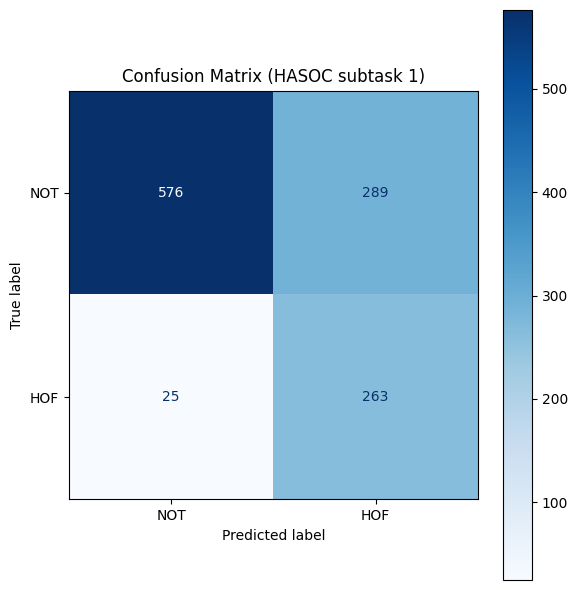

In [20]:
# --- Create test DataLoader or inference loader (unchanged) ---
test_loader = None
inference_only = False

# Defaults in case we never run evaluation
report = "No classification report available."
cm     = []  # empty or [[ ]] 
test_loss = test_acc = test_f1 = test_precision = test_recall = 0.0


if df_test is not None and len(df_test) > 0:
    has_labels = 'label' in df_test.columns
    test_dataset = TextClassificationDataset(
        texts = df_test['clean_text'].tolist(),
        labels= df_test['label'].tolist() if has_labels else None,
        tokenizer=tokenizer,
        max_len=MAX_LEN
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0
    )
    if has_labels:
        print(f"✔️ Built evaluation DataLoader for {len(test_dataset)} labeled test samples.")
    else:
        inference_only = True
        print(f"ℹ️ Built inference DataLoader for {len(test_dataset)} test samples (no labels).")
else:
    print("⚠️ No test data found; skipping test loader.")



# --- Run test set evaluation or inference ---
if test_loader is None:
    print("\nSkipping test set evaluation/inference (no test_loader).")

elif not inference_only:
    # ----- EVALUATION WITH LABELS -----
    print("\nEvaluating on Test Set...")
    test_loss, test_acc, test_f1, test_precision, test_recall, test_labels, test_preds = eval_model(
        model, test_loader, device, len(test_dataset), loss_fn
    )

    # Print metrics
    print(f"Test Loss:      {test_loss:.4f}")
    print(f"Test Accuracy:  {test_acc:.4f}")
    print(f"Test F1-score:  {test_f1:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall:    {test_recall:.4f}")

    # Build a properly ordered list of (int) labels and their names
    int_labels   = [v for _,v in sorted(LABEL_MAP.items(), key=lambda x: x[1])]
    target_names = [k for k,_ in sorted(LABEL_MAP.items(), key=lambda x: x[1])]

    report = classification_report(
        y_true=test_labels,
        y_pred=test_preds,
        labels=int_labels,          # ensure we include every class
        target_names=target_names,
        digits=4,
        zero_division=0
    )

    print("\nClassification Report:")
    print(report)

    # Confusion matrix display & save
    cm = confusion_matrix(test_labels, test_preds, labels=int_labels)
    disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(f'Confusion Matrix ({DATASET_TYPE} subtask {SUBTASK.upper()})')
    fig.tight_layout()
    
    cm_path = os.path.join(OUTPUT_DIR, f'cm_{DATASET_TYPE}_{SUBTASK}.png')
    fig.savefig(cm_path)
    print(f"Saved confusion matrix to {cm_path}")


elif inference_only:
    # ----- INFERENCE-ONLY, NO TRUE LABELS -----
    print("\nRunning inference on unlabeled Test Set...")
    model.eval()
    all_preds = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids      = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            all_preds.extend(preds)

    inv_label_map = {v:k for k,v in LABEL_MAP.items()}
    pred_strs = [inv_label_map[p] for p in all_preds]

    out_df = pd.DataFrame({
        'id':        df_test.get('id', range(len(all_preds))),
        'prediction':    all_preds,
        'prediction_str': pred_strs
    })
    out_path = os.path.join(OUTPUT_DIR,
    f'{DATASET_TYPE}_subtask{SUBTASK.upper()}_predictions.csv')

    out_df.to_csv(out_path, index=False)
    print(f"▶️ Inference done. Saved predictions to {out_path}")

    # No true labels → no report or confusion matrix
    report = "Inference-only mode; no classification report."
    cm     = []

    # How many examples to display
    n_display = 20

    # Get unique predicted class labels (e.g. ['NOT','OFF'])
    pred_classes = out_df['prediction_str'].unique().tolist()
    n_classes = len(pred_classes)
    # Compute how many per class (at least one)
    per_class = max(1, n_display // n_classes)

    # Sample per class
    sampled = (
        out_df
        .groupby('prediction_str', group_keys=False)
        .apply(lambda grp: grp.sample(min(len(grp), per_class), random_state=SEED))
    )

    # If we overshot (e.g. 2 classes × 3 = 6 > 5), just pick n_display at random
    if len(sampled) > n_display:
        sampled = sampled.sample(n_display, random_state=SEED)

    # Finally, shuffle the small sample so it’s not grouped by class
    sampled = sampled.sample(frac=1, random_state=SEED).reset_index(drop=True)

    print("\nSample predictions (balanced across predicted classes):")
    print(sampled)


## 10. Save Artifacts and Results

Save the trained model, tokenizer, training history plots, and final results.


Saving artifacts...
Best model and tokenizer saved to: model_output/best_model
Training history plot saved to model_output/training_history.png
Results saved to model_output/results_HASOC_subtask1.json


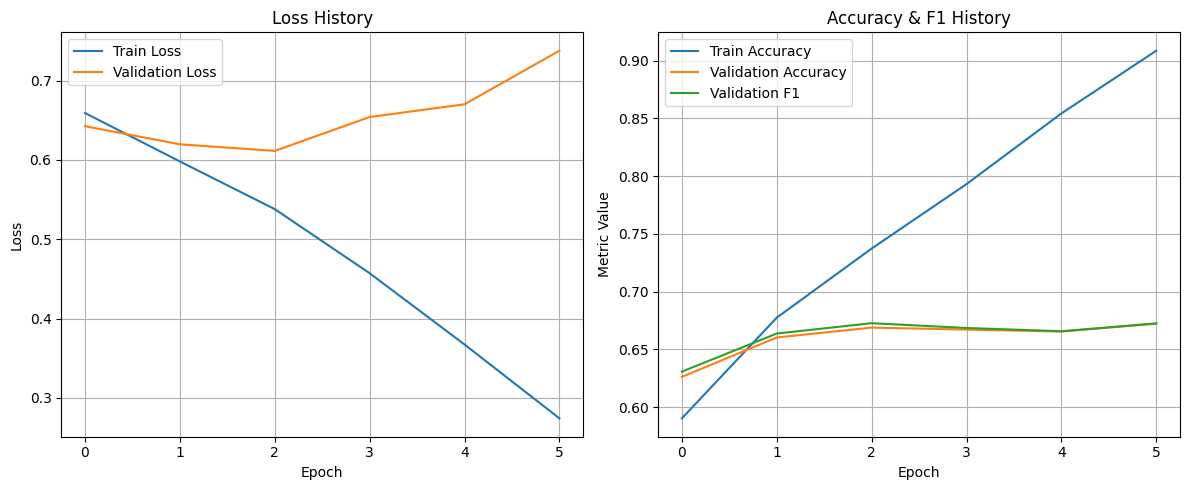

In [21]:
# After saving artifacts

print("\nSaving artifacts...")

# --- Save Model and Tokenizer ---
model_save_path = os.path.join(OUTPUT_DIR, 'best_model')
try:
    model.save_pretrained(model_save_path)
    tokenizer.save_pretrained(model_save_path)
    print(f"Best model and tokenizer saved to: {model_save_path}")
except Exception as e:
    print(f"Error saving model or tokenizer: {e}")

# --- Plot Training History ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.plot(history['val_f1'], label='Validation F1')
plt.title('Accuracy & F1 History')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
history_plot_path = os.path.join(OUTPUT_DIR, 'training_history.png')
try:
    plt.savefig(history_plot_path)
    print(f"Training history plot saved to {history_plot_path}")
    # plt.show() # Uncomment to display inline
except Exception as e:
    print(f"Error saving history plot: {e}")

# --- Save Configuration and Results to JSON ---
# Reuse config_dict from earlier
# Ensure confusion_matrix is serializable
cm_data = cm.tolist() if hasattr(cm, 'tolist') else cm

results = {
    'config': config_dict,
    'training_info': {
        'epochs_run': len(history['train_loss']),
        'total_training_time_seconds': total_training_time,
        'best_validation_loss': best_val_loss if best_model_state is not None else None,
        'best_epoch': best_epoch if best_model_state is not None else None
    },
    'history': history,
    'test_metrics': {
        'loss': test_loss,
        'accuracy': test_acc,
        'f1_score_weighted': test_f1,
        'precision_weighted': test_precision,
        'recall_weighted': test_recall
    },
    'classification_report': report,
    'confusion_matrix': cm_data
}

results_filename = f"results_{DATASET_TYPE}_subtask{SUBTASK.lower()}.json"
results_path     = os.path.join(OUTPUT_DIR, results_filename)

try:
    with open(results_path, 'w') as f:
        json.dump(results, f, indent=4)
    print(f"Results saved to {results_path}")
except Exception as e:
    print(f"Error saving results JSON: {e}")

## 11. Comparing Classification Reports

,dataset,subtask,accuracy,f1_weighted
0,HASOC,1,0.727667,0.745941
1,HASOC,2,0.727667,0.745941
2,HASOC,3,0.727667,0.745941
3,OffenseEval,a,0.727667,0.745941
4,OffenseEval,b,0.727667,0.745941
5,OffenseEval,c,0.727667,0.745941


| dataset     | subtask   |   accuracy |   f1_weighted |
|-------------|-----------|------------|---------------|
| HASOC       | 1         |   0.727667 |      0.745941 |
| HASOC       | 2         |   0.727667 |      0.745941 |
| HASOC       | 3         |   0.727667 |      0.745941 |
| OffenseEval | a         |   0.727667 |      0.745941 |
| OffenseEval | b         |   0.727667 |      0.745941 |
| OffenseEval | c         |   0.727667 |      0.745941 |


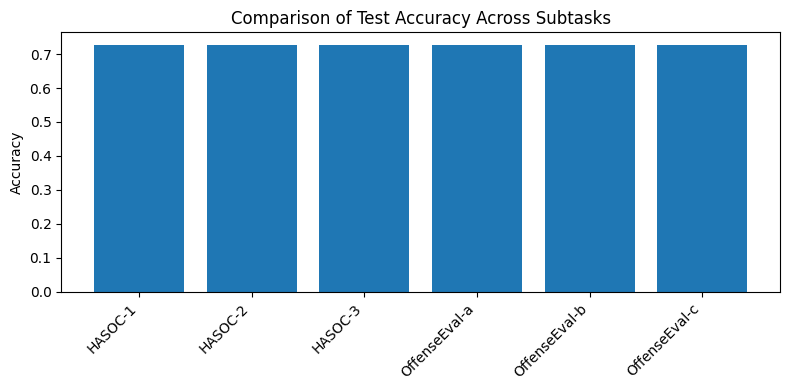

In [22]:

# List the datasets & subtasks you care about
configs = [
    ('HASOC',      '1'),
    ('HASOC',      '2'),
    ('HASOC',      '3'),
    ('OffenseEval','a'),
    ('OffenseEval','b'),
    ('OffenseEval','c'),
]

results = []
for ds, st in configs:
    # load the JSON you saved in each run: results_{DS}_subtask{ST}.json
    results_filename = f"results_{DATASET_TYPE}_subtask{SUBTASK.lower()}.json"
    results_path     = os.path.join(OUTPUT_DIR, results_filename)
    try:
        with open(results_path) as f:
            r = json.load(f)
        acc = r['test_metrics']['accuracy']
        f1  = r['test_metrics']['f1_score_weighted']
        results.append({
            'dataset': ds,
            'subtask': st,
            'accuracy': acc,
            'f1_weighted': f1
        })
    except FileNotFoundError:
        print(f"⚠️  Could not find {results_path}, skipping.")

# Build a DataFrame and display
df = pd.DataFrame(results)
display(df)

# (Optional) print as table
print(tabulate(df, headers='keys', tablefmt='github', showindex=False))

plt.figure(figsize=(8,4))
plt.bar(
    [f"{r['dataset']}-{r['subtask']}" for r in results],
    [r['accuracy'] for r in results]
)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Accuracy")
plt.title("Comparison of Test Accuracy Across Subtasks")
plt.tight_layout()
plt.show()


## 12. Explainability (Attention Visualization)

Load the trained model with `output_attentions=True` and visualize attention weights for a few examples from the test set. This provides a basic insight into which words the model focused on.


Reloading model for attention visualization...
Model reloaded successfully for visualization.

--- Visualizing Sample 1 (Index in test df: 767) ---
Text: when campus politics was politics,most of you were not yet born,uhuru kenyatta was still a criminal at icc at that time.mbappe had never scored any world cup goal .it was a fight btwn @USER and mike jacobs.gone are days! fuck delegate system.! #studentunionske #youth pic.twitter.com/yrdhvuxgxu
True Label: HOF (1)
Predicted Label: HOF (1)
Attention visualization saved to: model_output/attention_viz_sample_767.png


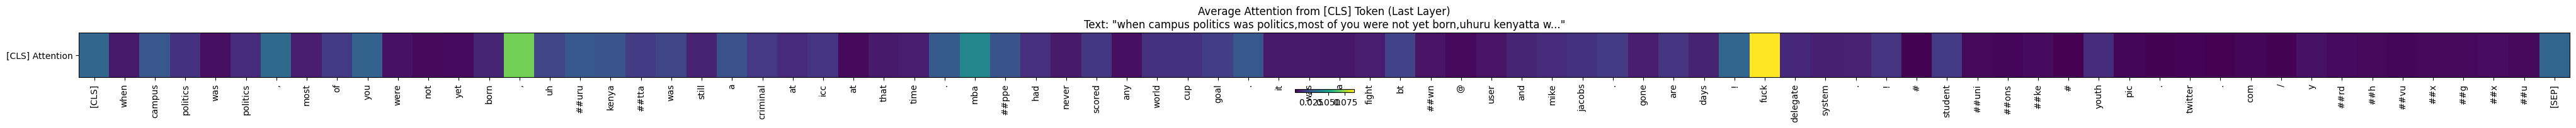


--- Visualizing Sample 2 (Index in test df: 461) ---
Text: @USER the first 2 would cripple the economy. the 3rd one is a joke concocted by an idiot bartender. there's no 'muslim ban'. if there was, your lying ass never wouldn't be here. if you do #5, i want reparations because i paid mine. #6 - #build the wall #wednesdaywisdom #maga
True Label: HOF (1)
Predicted Label: HOF (1)
Attention visualization saved to: model_output/attention_viz_sample_461.png


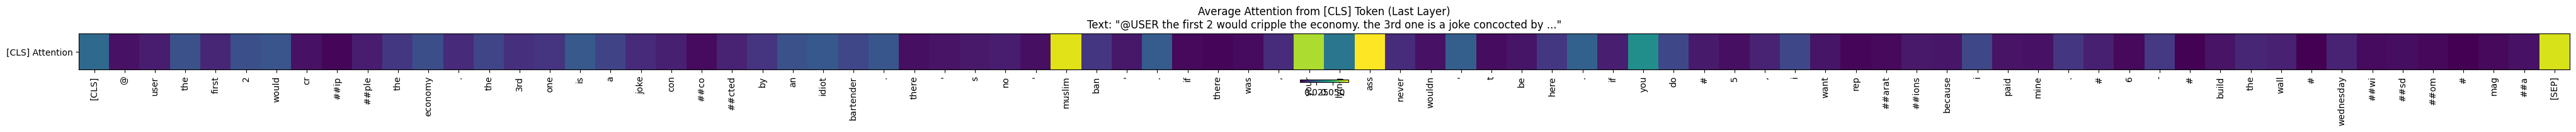


--- Visualizing Sample 3 (Index in test df: 787) ---
Text: if you attach huge importance to the gfa, you’d better revoke a50 asap !!! otherwise you’ll not be taken serious! more empty words or revoke a50!!??
True Label: NOT (0)
Predicted Label: HOF (1)
Attention visualization saved to: model_output/attention_viz_sample_787.png


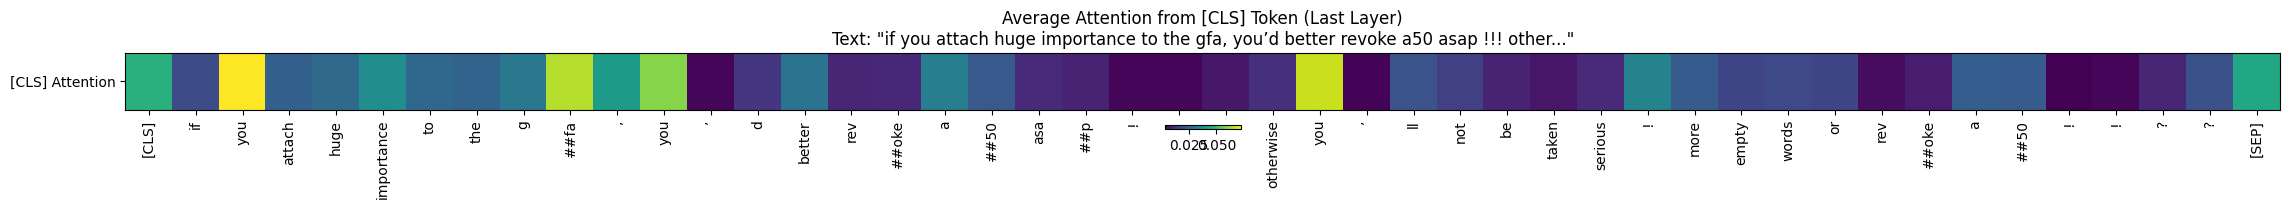


--- Visualizing Sample 4 (Index in test df: 593) ---
Text: boris johnson: what does his tour around the uk tell us? HTTPURL …
True Label: NOT (0)
Predicted Label: NOT (0)
Attention visualization saved to: model_output/attention_viz_sample_593.png


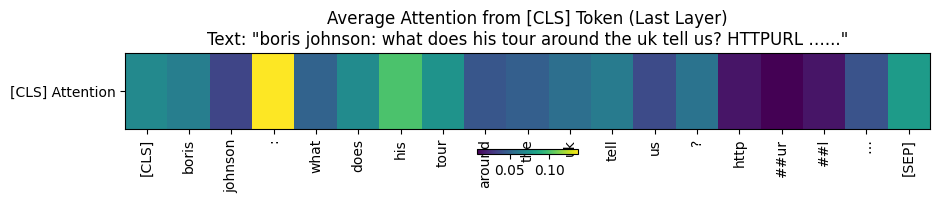


--- Visualizing Sample 5 (Index in test df: 388) ---
Text: “as we prepare for our bright future after brexit, it’s vital we renew the ties binding our united kingdom. important projects like growth deals – today backed with £300m new funding – will open up opportunities across our union.” - pm @USER
True Label: NOT (0)
Predicted Label: NOT (0)
Attention visualization saved to: model_output/attention_viz_sample_388.png


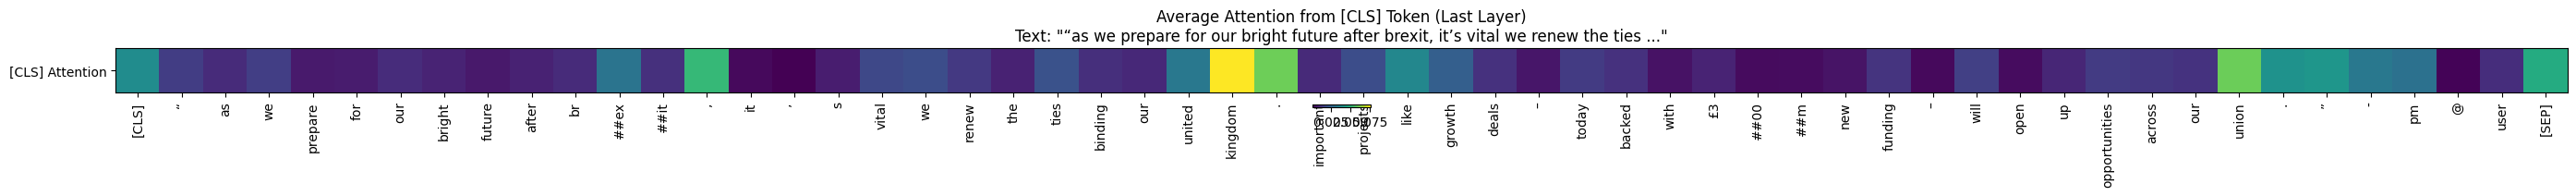

In [23]:
def visualize_attention(model: BertForSequenceClassification, tokenizer: BertTokenizer, text: str, device: torch.device, max_len: int, fig_title: str = "Average Attention from [CLS] Token (Last Layer)"):
    """Generates a basic attention visualization for a given text."""

    # Preprocess and tokenize the text
    processed_text = preprocess_text(text)
    inputs = tokenizer.encode_plus(
        processed_text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    ).to(device) # Move inputs to device

    # Ensure model outputs attentions (should have been loaded this way)
    if not model.config.output_attentions:
        print("Error: Model was not loaded with output_attentions=True. Cannot visualize attention.")
        print("Please reload the model with `output_attentions=True` before calling this function.")
        return None, None

    # Get model output (including attentions)
    model.eval()
    with torch.no_grad():
        # Passing labels here is optional for visualization, but doesn't hurt
        outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])

    # Extract attentions (tuple of tensors, one for each layer)
    # Shape: (num_layers, batch_size, num_heads, seq_len, seq_len)
    attentions = outputs.attentions

    # --- Process Attentions (Example: Average last layer's attention from [CLS]) ---
    # Get attentions from the last layer
    last_layer_attentions = attentions[-1].squeeze(0) # Shape: (num_heads, seq_len, seq_len)

    # Average attention scores across all heads
    avg_attention = torch.mean(last_layer_attentions, dim=0) # Shape: (seq_len, seq_len)

    # Focus on attention from the [CLS] token (index 0) to all other tokens
    # Squeeze(0) removes the batch dimension (batch_size=1)
    cls_attention = avg_attention[0, :].cpu().numpy() # Shape: (seq_len,)

    # Get tokens from the input_ids
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'].squeeze(0).cpu().numpy())

    # Filter out padding tokens (ids beyond the attention mask)
    # Find the last non-padded token index based on attention mask
    valid_len = inputs['attention_mask'].squeeze(0).sum().item()
    valid_tokens = tokens[:valid_len]
    valid_cls_attention = cls_attention[:valid_len]

    # Normalize attention scores for better visualization (optional, but often helps)
    # Normalize so scores sum to 1 across the sequence
    attention_sum = np.sum(valid_cls_attention[1:]) # Sum attention excluding CLS itself
    if attention_sum > 0:
         valid_cls_attention[1:] = valid_cls_attention[1:] / attention_sum

    # --- Plotting ---
    # Adjust figure size based on number of tokens
    fig_width = max(8, len(valid_tokens) * 0.5) # Minimum width 8, then proportional to tokens
    fig, ax = plt.subplots(figsize=(fig_width, 2))
    im = ax.imshow([valid_cls_attention], cmap='viridis', aspect='auto')

    ax.set_xticks(np.arange(len(valid_tokens)))
    ax.set_yticks([0])
    ax.set_xticklabels(valid_tokens, rotation=90, fontsize=10)
    ax.set_yticklabels(['[CLS] Attention'])

    # Add colorbar
    cbar = fig.colorbar(im, orientation='horizontal', fraction=0.05, pad=0.2)
    # Optional: Add value labels on heatmap (can be noisy for many tokens)
    # for i in range(len(valid_tokens)):
    #     ax.text(i, 0, f'{valid_cls_attention[i]:.2f}', ha='center', va='center', color='white' if valid_cls_attention[i] > np.mean(valid_cls_attention) else 'black', fontsize=8)

    plt.title(f'{fig_title}\nText: "{text[:80]}..."') # Truncate text for title
    plt.tight_layout()

    return fig, processed_text # Return figure and processed text

# --- Reload model with output_attentions=True ---
# Check if test_loader is available, otherwise cannot visualize on test data
if test_loader is not None:
    print("\nReloading model for attention visualization...")
    # Model was saved to OUTPUT_DIR/best_model
    model_path = os.path.join(OUTPUT_DIR, 'best_model')

    try:
        # Critical: Load with output_attentions=True
        # We load from_pretrained from the saved directory, not from the internet
        model_for_viz = BertForSequenceClassification.from_pretrained(model_path, output_attentions=True)
        model_for_viz.to(device)
        model_for_viz.eval() # Ensure evaluation mode
        print("Model reloaded successfully for visualization.")

        # Get label names from the map for printing
        target_names = [k for k, v in sorted(LABEL_MAP.items(), key=lambda item: item[1])]

        # --- Visualize Attention for Sample Texts ---
        # Take a few samples from the test set dataframe (df_test)
        num_samples_to_viz = 5
        # Ensure df_test is not None and has enough rows
        if df_test is not None and len(df_test) > 0:
            sample_indices = df_test.sample(n=min(num_samples_to_viz, len(df_test)), random_state=SEED).index

            for i, idx in enumerate(sample_indices):
                # Use the already cleaned text from the dataframe
                original_text = df_test.loc[idx, 'clean_text']

                # Try to get the true label if available, otherwise use dummy 0
                true_label_int = df_test.loc[idx, 'label'] if 'label' in df_test.columns else 0
                try:
                    true_label_str = target_names[true_label_int]
                except (IndexError, TypeError):
                     true_label_str = f"Unknown ({true_label_int})"


                print(f"\n--- Visualizing Sample {i+1} (Index in test df: {idx}) ---")
                print(f"Text: {original_text}")
                print(f"True Label: {true_label_str} ({true_label_int})")

                # Predict with the visualization model to get the predicted label
                inputs = tokenizer.encode_plus(original_text, return_tensors='pt', max_length=MAX_LEN, padding='max_length', truncation=True).to(device)
                with torch.no_grad():
                    outputs = model_for_viz(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
                pred_label_int = torch.argmax(outputs.logits, dim=1).item()
                try:
                     pred_label_str = target_names[pred_label_int]
                except (IndexError, TypeError):
                     pred_label_str = f"Unknown ({pred_label_int})"
                print(f"Predicted Label: {pred_label_str} ({pred_label_int})")

                # Generate visualization
                fig, _ = visualize_attention(model_for_viz, tokenizer, original_text, device, MAX_LEN)
                if fig:
                    viz_path = os.path.join(OUTPUT_DIR, f'attention_viz_sample_{idx}.png')
                    try:
                         fig.savefig(viz_path, bbox_inches='tight')
                         print(f"Attention visualization saved to: {viz_path}")
                         plt.show() # Display inline
                    except Exception as e:
                         print(f"Error saving attention plot for sample {idx}: {e}")
                         plt.close(fig) # Close the figure if saving failed
                else:
                     print("Skipping visualization due to error in function.")
        else:
            print("Cannot visualize attention: Test dataframe is empty or None.")

    except Exception as e:
        print(f"\nError during attention visualization setup or execution: {e}")
        print("Skipping attention visualization.")

else:
     print("\nSkipping attention visualization as test data is not available.")



## 12. Conclusion and Next Steps

This notebook demonstrated the process of fine-tuning BERT for hate speech detection, optionally using FGM for adversarial robustness, evaluating performance, and gaining basic insights via attention visualization.

**Potential Next Steps:**

*   **Hyperparameter Tuning:** Systematically tune `LEARNING_RATE`, `BATCH_SIZE`, `MAX_LEN`, `ADVERSARIAL_EPS`, `PATIENCE` using tools like Optuna or Weights & Biases Sweeps.
*   **Dataset Adaptability:** Refine the `load_and_preprocess_data` function to more robustly handle different dataset formats (especially OffenseEval parts) or create dataset-specific loading functions.
*   **Advanced Adversarial Training:** Implement PGD (Projected Gradient Descent) or explore libraries like TextAttack for more sophisticated attacks and defenses.
*   **Enhanced Explainability:** Integrate libraries like Captum to use methods like Integrated Gradients, SHAP, or LIME for more detailed feature importance analysis.
*   **Error Analysis:** Analyze misclassified examples from the test set to understand model weaknesses and potential biases.
*   **Model Exploration:** Experiment with other transformer architectures like RoBERTa, DeBERTa, etc.
*   **Data Augmentation:** Incorporate techniques like back-translation or synonym replacement (e.g., using `nlpaug`) during training.
*   **Weights & Biases Integration:** Uncomment and configure the (currently missing) wandb integration code for comprehensive experiment tracking.
*   **Deployment:** Explore ways to deploy the trained model for real-time inference using libraries like FastAPI or Flask.